# **Unified classification and risk-stratification in Acute Myeloid Leukemia**


>>> # **Response reviewers** : 

In [5]:
R.version.string

[1] "R version 4.1.0 (2021-05-18)"

In [6]:
options(warn=-1)

# # Step 1: Install and load missing libraries
# start_time <- Sys.time()
some_packages <- c("ggplot2","reshape2","data.table","stringr","gridExtra","survival","survminer","bshazard","colorspace","mstate","ggrepel","cmprsk","networkD3","grid")
for (package in some_packages){
#   if(!require(package,character.only = TRUE)){
#     install.packages(package,character.only = TRUE)
#   }
  library(package,character.only=TRUE)
}
# end_time <- Sys.time()
# paste0("It takes :", round(end_time-start_time,2), " minutes to install all the libraries (survminer takes a LOT of time!)")

In [7]:
source('src/tools_analysis_bis.R')

# **Responses:**

# ***Reviewer 1.***

## ***(b) does the OS differ depending on the therapy received (high intensity vs. low intensity) with respect to the complex karyotype group?***

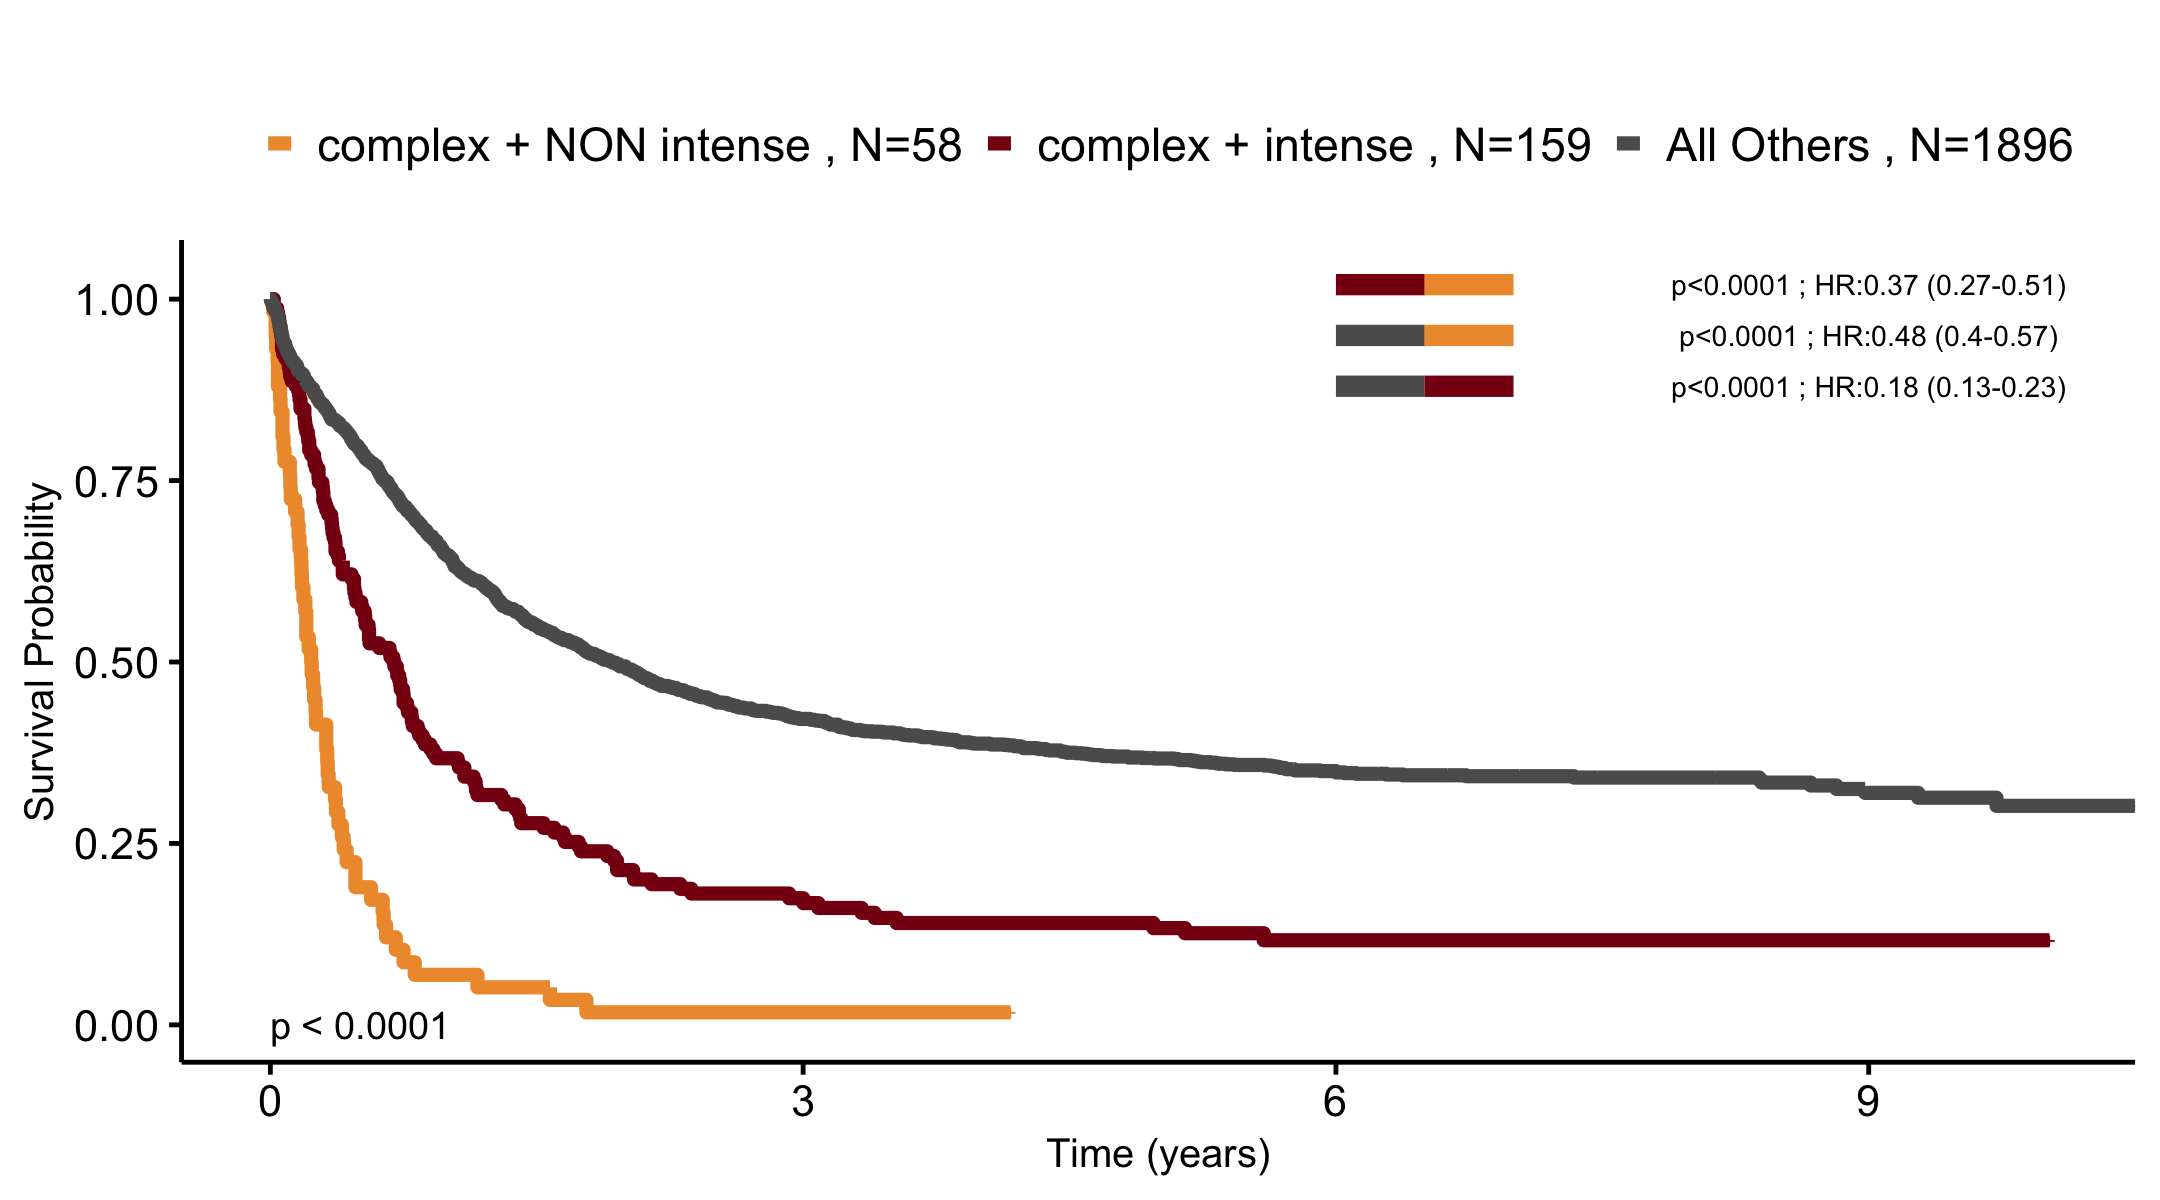

In [19]:
list_intensively_treated <- readRDS("data/list_intensively_treated.rds")
df_all <- df_final
df_all$comparison <- ifelse(rownames(df_final) %in% list_intensively_treated & df_final$complex==1 ,"complex + intense",
                        ifelse(df_final$complex==1 ,"complex + NON intense","All Others"))
df_all$comparison <- factor(df_all$comparison,levels=c("complex + NON intense","complex + intense","All Others"))

# Surv
surv_object <- Surv(time = df_all$os, event = df_all$os_status)
fit <- survfit(surv_object ~ comparison, data = df_all)

# Get pvalues, HR and CI for the 3 comparisons
tmp <-  df_all[df_all$comparison %in% c("complex + intense","complex + NON intense"),]
tmp$comparison <- factor(tmp$comparison,levels=c("complex + NON intense","complex + intense"))
res <- get_pvalue_and_HR(formula=Surv(os,os_status)~comparison,data = tmp)

tmp <-  df_all[df_all$comparison %in% c("complex + intense","All Others"),]
tmp$comparison <- factor(tmp$comparison,levels=c("complex + intense","All Others"))
res1 <- get_pvalue_and_HR(formula=Surv(os,os_status)~comparison,data = tmp)

tmp <-  df_all[df_all$comparison %in% c("complex + NON intense","All Others"),]
tmp$comparison <- factor(tmp$comparison,levels=c("complex + NON intense","All Others"))
res2 <- get_pvalue_and_HR(formula=Surv(os,os_status)~comparison,data = tmp)

# Surv Plot and Risk table
set_notebook_plot_size(25,10)
surv <- plot_surv_curves(fit,y="Survival Probability",xlim=c(0,10),break.x.by=3,ylim=c(0,1.03),pval=T,vals=c("#EE9937","#870C14","#5C5C5C"),risk.tab=T,pval.coord = c(0,0))

# Surv Plot
surv_plot <- surv$plot+
             annotate("segment", x = c(6,6.5,6,6.5,6,6.5),
                                 xend = c(6.5,7,6.5,7,6.5,7),
                                 y = c(1.02,1.02,0.95,0.95,0.88,0.88), 
                                 yend = c(1.02,1.02,0.95,0.95,0.88,0.88),
                                 size=6,
                                 colour = c("#870C14","#EE9937","#5C5C5C","#EE9937","#5C5C5C","#870C14"))+ 
             annotate(geom="text", x=rep(9,3) , y=c(1.02,0.95,0.88), label=c(res,res1,res2),size=6)

set_notebook_plot_size(18,10)
surv_plot


## ***(e) needs more details in the methods regarding the hierarchical clustering. Why does CEBPAbi not cluster with other ELN2017 favorable AMLs?***

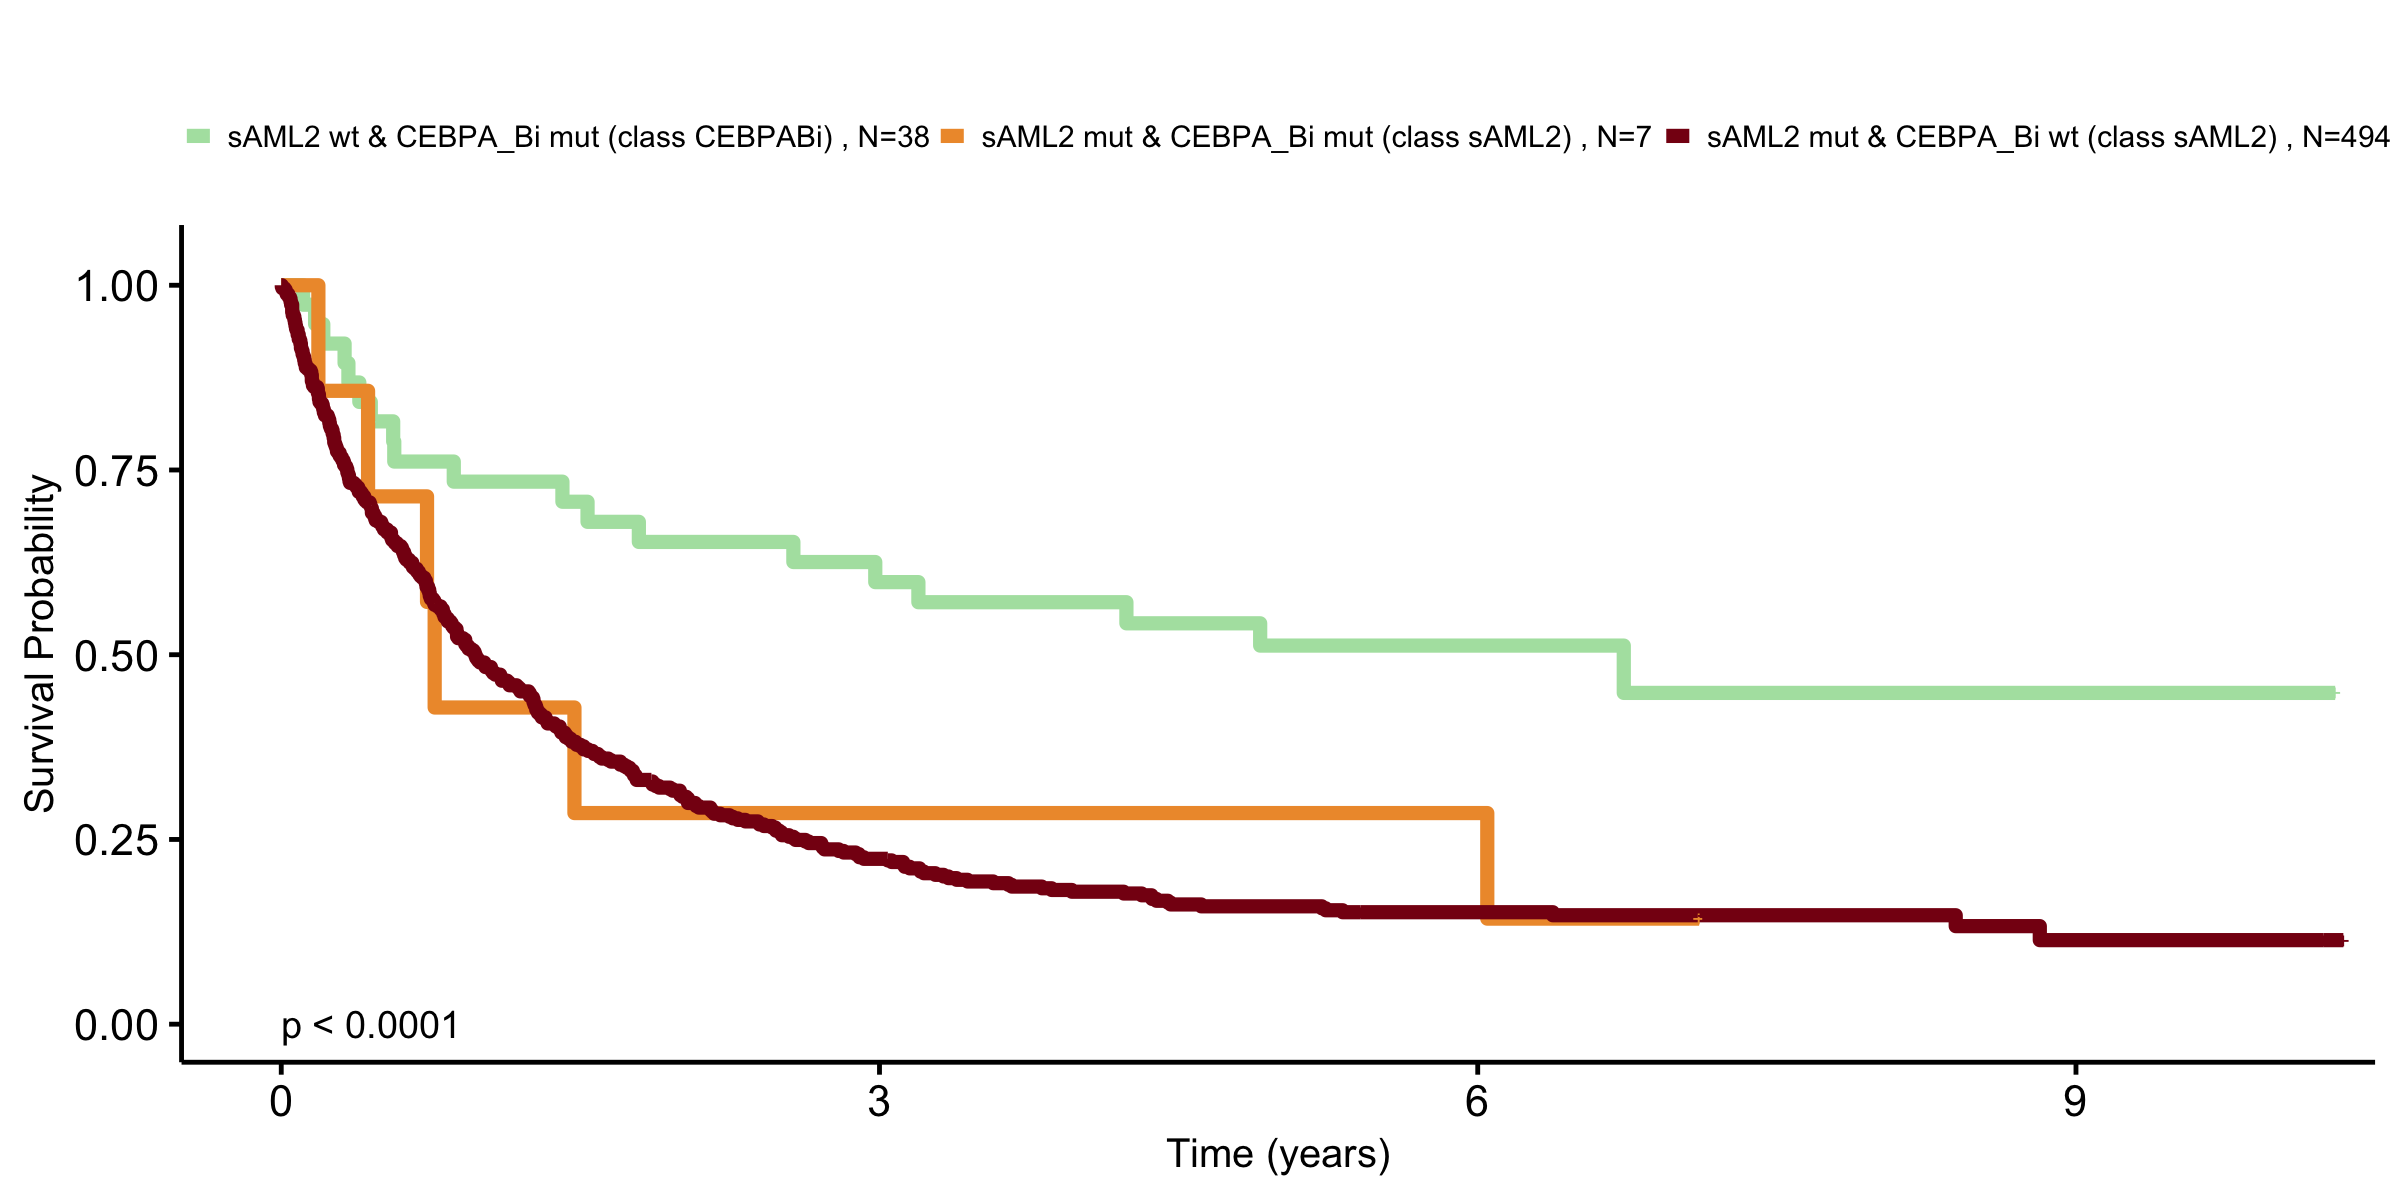

In [20]:
df <- df_final
df$comparison <- ifelse(df$princ_comp=="CEBPA_bi","sAML2 wt & CEBPA_Bi mut (class CEBPABi)",
              ifelse(df$princ_comp=="sAML2" & df$CEBPA_bi==1,"sAML2 mut & CEBPA_Bi mut (class sAML2)" ,
                  ifelse(df$princ_comp=="sAML2" & df$CEBPA_bi==0,"sAML2 mut & CEBPA_Bi wt (class sAML2)" , "All Others")))    

df$comparison <- factor(df$comparison,levels=c("sAML2 wt & CEBPA_Bi mut (class CEBPABi)","sAML2 mut & CEBPA_Bi mut (class sAML2)","sAML2 mut & CEBPA_Bi wt (class sAML2)","All Others"))

df <- df[df$comparison!="All Others",]

# Surv
surv_object <- Surv(time = df$os, event = df$os_status)
fit <- survfit(surv_object ~ comparison, data = df)

set_notebook_plot_size(25,10)
surv <- plot_surv_curves(fit,y="Survival Probability",xlim=c(0,10),break.x.by=3,ylim=c(0,1.03),pval=T,vals=c("#AFE1AF","#EE9937","#870C14","#5C5C5C"),
risk.tab=T,pval.coord = c(0,0),font.legend = 18)

# Surv Plot
surv_plot <- surv$plot
set_notebook_plot_size(20,10)
surv_plot

# ***Reviewer 2.***

### ***b) “These validate established WHO2016 entities, resolve provisional subgroups and characterize novel entities that describe 33.3% of AML patients 149 (S.Figure 6)”. There should be a multiple-multiple mapping for this claim. Each patient should have classification labels in WHO, in NEJM, and in this study. The supp figure 6 looks to me that the clusters are not complete coherent to current standards, which is OK and encouraging. There are apparently some samples are re-classified to other categories, which can be an improvement that the study could contribute to clinical practice because it corrects some misclassifications by current methods.***

In [21]:
### Part 1: Prepare the data to characterize WHO, NEJM and MRC Classifications

WHO_2016_defining_events <- c("t(8;21)","inv(16)","t(9;11)","t(6;9)","inv(3)","t(15;17)","CEBPA_bi","NPM1")
WHO_other_events <- c("-7","t(8;16)","-5","t(3;21)","t(1;3)","-13","t(2;11)","-11","t(5;12)","-12","t(5;7)","-9","t(5;17)","t(5;10)","t(3;5)")   # new to add to WHO
WHO_2016_defining_events <- c(WHO_2016_defining_events,WHO_other_events)
WHO_2016_defining_events <- intersect(colnames(df_final),WHO_2016_defining_events)
WHO_2016_provisional_events <- c("t(9;22)","RUNX1")


# 1. WHO 2016 Part:

df_WHO<- df_final
df_WHO$classes <- ifelse(rowSums(df_WHO[,WHO_2016_defining_events])>0,"WHO",
                         ifelse(rowSums(df_WHO[,WHO_2016_defining_events])==0 & (df_WHO$RUNX1==1 | df_WHO[,"t(9;22)"]==1),"Provisional","No Class"))
df_WHO$Classification <- "WHO 2016"

percentage_classified_WHO <- 100*round(nrow(df_WHO[df_WHO$classes!="No Class",])/nrow(df_WHO),3)


# 2. NEJM  2016 Part:
df_NEJM <- df_final
df_NEJM$classes <- ifelse(df_NEJM$NPM1==1,"WHO",
                    ifelse(rowSums(df_NEJM[,c("SRSF2","SF3B1","U2AF1_p.S34","U2AF1_p.Q157","ZRSR2","ASXL1","STAG2","BCOR",
                          "MLL","EZH2","PHF6","RUNX1")])>1,"NEJM",      
                    ifelse(df_NEJM$TP53==1 | df_NEJM$complex==1 | df_NEJM[,"+8"]==1,"NEJM",
                    ifelse(df_NEJM[,"inv(16)"]==1,"WHO",
                    ifelse(df_NEJM$CEBPA_bi==1,"WHO",
                    ifelse(df_NEJM[,"t(15;17)"]==1,"WHO",      
                    ifelse(df_NEJM[,"t(8;21)"]==1,"WHO",
                    ifelse(df_NEJM[,"t(9;11)"]==1,"WHO",
                    ifelse(df_NEJM[,"inv(3)"]==1,"WHO",
                    ifelse(df_NEJM$IDH2_p.R172==1,"NEJM",
                    ifelse(df_NEJM[,"t(6;9)"]==1,"WHO",
                    ifelse(rowSums(df_NEJM[,c("SRSF2","SF3B1","U2AF1_p.S34","U2AF1_p.Q157","ZRSR2","ASXL1","STAG2","BCOR",
                          "MLL","EZH2","PHF6","RUNX1")])==1,"NEJM", 
                    ifelse(rowSums(df_NEJM[,WHO_2016_defining_events])>0,"WHO",
                           "No Class")))))))))))))


df_NEJM$Classification <- "NEJM 2016"

percentage_classified_NEJM <- 100*round(nrow(df_NEJM[df_NEJM$classes!="No Class",])/nrow(df_NEJM),3)

# 3. MRC Part: 

df_MRC <- df_final

df_MRC$classes <- ifelse(df_MRC$princ_comp %in% c("t_15_17","t_8_21","inv_16","t_6_9","inv_3","t_11","CEBPA_bi","NPM1"),"WHO",
                      ifelse(df_MRC$princ_comp %in% c("TP53_complex"),"NEJM",
                          ifelse(df_MRC$princ_comp %in% c("sAML1","sAML2") ,"NEJM refined",
                              ifelse(df_MRC$princ_comp %in% c("DNMT3A_IDH1_2","WT1","Trisomies"),"New Classes" ,
                                  ifelse(rowSums(df_MRC[,WHO_2016_defining_events])>0,"WHO","No Class")))))


df_MRC$Classification <- "MRC"

percentage_classified_MRC <- 100*round(nrow(df_MRC[df_MRC$classes!="No Class",])/nrow(df_MRC),3)

# All together

df_all <- rbind(df_WHO,df_NEJM,df_MRC)
df_all$classes <- factor(df_all$classes, levels=c("No Class","New Classes","NEJM refined","NEJM","Provisional","WHO"))
df_all$Classification <- factor(df_all$Classification,levels=c("MRC","NEJM 2016","WHO 2016"))



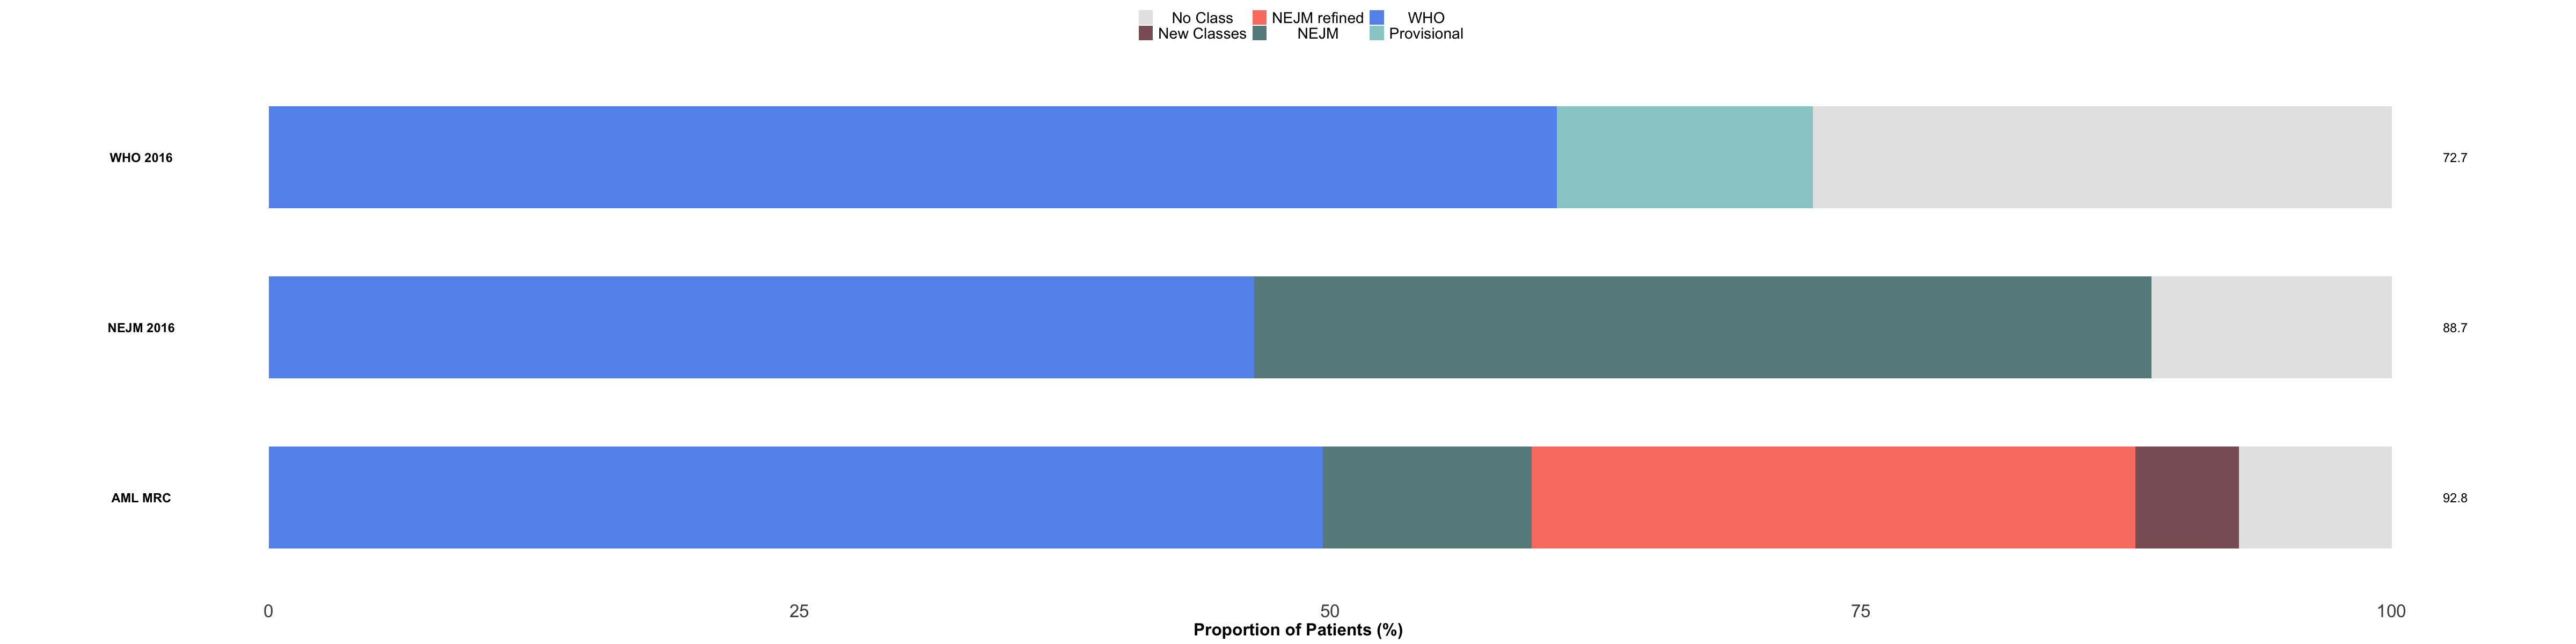

In [22]:
# Initial Supp Figure 6:
color_plot <- list()
color_plot["No Class"] <- "#E5E5E5"
color_plot["New Classes"] <- "#8B5F65"
color_plot["NEJM refined"] <- "salmon"
color_plot["NEJM"] <- "paleturquoise4"
color_plot["WHO"] <- "#6495ED"
color_plot["Provisional"] <- "paleturquoise3"



set_notebook_plot_size(40,10)
p <- ggplot(df_all,aes(x=reorder(Classification,Classification),fill=classes))+geom_bar(aes(y = 300 *(..count..)/sum(..count..)),stat="count",width=0.6)+
     scale_fill_manual(values=unlist(color_plot),limits=names(color_plot))+
     ylab("Proportion of Patients (%)")+
     xlab("")+
     theme_bw()+
     theme(panel.border = element_rect(colour = "black", fill=NA, size=0),
           legend.text = element_text(hjust = 0.5,size=17),legend.title = element_blank(),legend.position="top",
           plot.title = element_text(hjust = 0.5,size=25),
           axis.text.y=element_blank(),axis.ticks=element_blank(),axis.text.x=element_text(size=20),
           axis.title=element_text(size=19,face="bold"),
           panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank())+
     coord_flip()+
     annotate("text",label=c(percentage_classified_MRC,percentage_classified_NEJM,percentage_classified_WHO),x=c(1,2,3),y=103,size=5)+
     annotate("text",label=c("AML MRC","NEJM 2016","WHO 2016"),x=c(1,2,3),y=c(-6,-6,-6),size=5,fontface="bold")
p


In [23]:
library(networkD3)

In [24]:
# Sankey Plot 1 : WHO and NEJM Classification

df_WHO_NEJM <- data.frame(cbind(WHO_classes=df_WHO$classes,NEJM_classes=df_NEJM$classes))

df_WHO_NEJM$WHO_classes_val <- ifelse(df_WHO_NEJM$WHO_classes=="WHO",0,
                                     ifelse(df_WHO_NEJM$WHO_classes=="Provisional",1,2))
df_WHO_NEJM$NEJM_classes_val <- ifelse(df_WHO_NEJM$NEJM_classes=="WHO",3,
                                     ifelse(df_WHO_NEJM$NEJM_classes=="NEJM",4,5))

list_val_mapping <- list()
count <- 1
for (i in c(0,1,2)){
    for (j in c(3,4,5)){
        list_val_mapping[count] <- nrow(df_WHO_NEJM[df_WHO_NEJM$WHO_classes_val==i &
                                                                df_WHO_NEJM$NEJM_classes_val==j,])
        count <- count+1
    }
}

nodes = data.frame("name" = c("WHO", "Provisional", "No Class", "WHO", "NEJM", "No Class"))

## create edges with weights
links = as.data.frame(matrix(c(0, 3, list_val_mapping[[1]], 
                               0, 4, list_val_mapping[[2]], 
                               0, 5, list_val_mapping[[3]], 
                               1, 3, list_val_mapping[[4]], 
                               1, 4, list_val_mapping[[5]], 
                               1, 5, list_val_mapping[[6]],
                               2, 3, list_val_mapping[[7]], 
                               2, 4, list_val_mapping[[8]], 
                               2, 5, list_val_mapping[[9]]),
                               byrow = TRUE, ncol = 3))


## set column names for links
names(links) = c("source", "target", "value")

## add edge types for coloring purpose
links$group = c("type_0", 
                "type_1",
                "type_2",
                "type_3",
                "type_4",
                "type_5",
                "type_6",
                "type_7",
                "type_8")
links


# Sankey Plot 2 : WHO and MRC Classification
df_WHO_MRC <- data.frame(cbind(WHO_classes=df_WHO$classes,MRC_classes=df_MRC$classes))

df_WHO_MRC$WHO_classes_val <- ifelse(df_WHO_MRC$WHO_classes=="WHO",0,
                                     ifelse(df_WHO_MRC$WHO_classes=="Provisional",1,2))
df_WHO_MRC$MRC_classes_val <- ifelse(df_WHO_MRC$MRC_classes=="WHO",3,
                                     ifelse(df_WHO_MRC$MRC_classes=="NEJM",4,
                                            ifelse(df_WHO_MRC$MRC_classes=="NEJM refined",5,
                                                   ifelse(df_WHO_MRC$MRC_classes=="New Classes",6,7))))

list_val_mapping <- list()
count <- 1
for (i in c(0,1,2)){
    for (j in c(3,4,5,6,7)){
        list_val_mapping[count] <- nrow(df_WHO_MRC[df_WHO_MRC$WHO_classes_val==i &
                                                                df_WHO_MRC$MRC_classes_val==j,])
        count <- count+1
    }
}

nodes = data.frame("name" =  c("WHO","Provisional","No Class","WHO", "NEJM", "NEJM_refined", "New Classes", "No Class"))

## create edges with weights
links = as.data.frame(matrix(c(0, 3, list_val_mapping[[1]], 
                               0, 4, list_val_mapping[[2]], 
                               0, 5, list_val_mapping[[3]],
                               0, 6, list_val_mapping[[4]], 
                               0, 7, list_val_mapping[[5]], 
                               1, 3, list_val_mapping[[6]],
                               1, 4, list_val_mapping[[7]], 
                               1, 5, list_val_mapping[[8]], 
                               1, 6, list_val_mapping[[9]],
                               1, 7, list_val_mapping[[10]], 
                               2, 3, list_val_mapping[[11]], 
                               2, 4, list_val_mapping[[12]],
                               2, 5, list_val_mapping[[13]], 
                               2, 6, list_val_mapping[[14]], 
                               2, 7, list_val_mapping[[15]]),
                               byrow = TRUE, ncol = 3))


## set column names for links
names(links) = c("source", "target", "value")

## add edge types for coloring purpose
links$group = c("type_0", 
                "type_1",
                "type_2",
                "type_3",
                "type_4",
                "type_5",
                "type_6",
                "type_7",
                "type_8",
                "type_9", 
                "type_10",
                "type_11",
                "type_12",
                "type_13",
                "type_14")
links

## Draw Sankey Diagram
sankey_WHO_MRC <- sankeyNetwork(Links = links, Nodes = nodes,
 Source = "source", Target = "target",
 Value = "value", NodeID = "name",
 fontSize = 20, nodeWidth = 40,colourScale = 'd3.scaleOrdinal()
            .range(["#6495ED","#96cdcd","#E5E5E5","#668b8b","salmon","#8B5F65"])')

# Sankey Plot 3 : NEJM and MRC Classification

df_NEJM_MRC <- data.frame(cbind(NEJM_classes=df_NEJM$classes,MRC_classes=df_MRC$classes))

df_NEJM_MRC$NEJM_classes_val <- ifelse(df_NEJM_MRC$NEJM_classes=="WHO",0,
                                     ifelse(df_NEJM_MRC$NEJM_classes=="NEJM",1,2))
df_NEJM_MRC$MRC_classes_val <- ifelse(df_NEJM_MRC$MRC_classes=="WHO",3,
                                     ifelse(df_NEJM_MRC$MRC_classes=="NEJM",4,
                                            ifelse(df_NEJM_MRC$MRC_classes=="NEJM refined",5,
                                                   ifelse(df_NEJM_MRC$MRC_classes=="New Classes",6,7))))


list_val_mapping <- list()
count <- 1
for (i in c(0,1,2)){
    for (j in c(3,4,5,6,7)){
        list_val_mapping[count] <- nrow(df_NEJM_MRC[df_NEJM_MRC$NEJM_classes_val==i &
                                                                df_NEJM_MRC$MRC_classes_val==j,])
        count <- count+1
    }
}

nodes = data.frame("name" =  c("WHO","NEJM","No Class","WHO", "NEJM", "NEJM_refined", "New Classes", "No Class"))

## create edges with weights
links = as.data.frame(matrix(c(0, 3, list_val_mapping[[1]], 
                               0, 4, list_val_mapping[[2]], 
                               0, 5, list_val_mapping[[3]],
                               0, 6, list_val_mapping[[4]], 
                               0, 7, list_val_mapping[[5]], 
                               1, 3, list_val_mapping[[6]],
                               1, 4, list_val_mapping[[7]], 
                               1, 5, list_val_mapping[[8]], 
                               1, 6, list_val_mapping[[9]],
                               1, 7, list_val_mapping[[10]], 
                               2, 3, list_val_mapping[[11]], 
                               2, 4, list_val_mapping[[12]],
                               2, 5, list_val_mapping[[13]], 
                               2, 6, list_val_mapping[[14]], 
                               2, 7, list_val_mapping[[15]]),
                               byrow = TRUE, ncol = 3))


## set column names for links
names(links) = c("source", "target", "value")

## add edge types for coloring purpose
links$group = c("type_0", 
                "type_1",
                "type_2",
                "type_3",
                "type_4",
                "type_5",
                "type_6",
                "type_7",
                "type_8",
                "type_9", 
                "type_10",
                "type_11",
                "type_12",
                "type_13",
                "type_14")
links

source,target,value,group
<dbl>,<dbl>,<dbl>,<chr>
0,3,981,type_0
0,4,301,type_1
0,5,0,type_2
1,3,0,type_3
1,4,252,type_4
1,5,3,type_5
2,3,0,type_6
2,4,340,type_7
2,5,236,type_8


source,target,value,group
<dbl>,<dbl>,<dbl>,<chr>
0,3,1006,type_0
0,4,174,type_1
0,5,90,type_2
0,6,12,type_3
0,7,0,type_4
1,3,4,type_5
1,4,7,type_6
1,5,241,type_7
1,6,0,type_8


source,target,value,group
<dbl>,<dbl>,<dbl>,<chr>
0,3,968,type_0
0,4,0,type_1
0,5,6,type_2
0,6,7,type_3
0,7,0,type_4
1,3,50,type_5
1,4,208,type_6
1,5,588,type_7
1,6,44,type_8


# **WHO 2016 Classification and NEJM 2016 Classification.**
<img src='https://drive.google.com/uc?id=1LlkLcOudEYv4BNDOqK0Sf2NXD4AUEubd'>

# **WHO 2016 Classification and MRC Classification.**
<img src='https://drive.google.com/uc?id=1Us8slIeaGU-A4yjIZEFilc6WznM4aKUC'>

# **NEJM 2016 Classification and MRC Classification.**
<img src='https://drive.google.com/uc?id=1R7CYtl__EboUhBikeKWur_kUi3U3ubC5'>

## ***4. In “A multi-state model for disease progression”:a) The multi-state model is interesting. Comparing Figure 3 to Supp Fig. 31, I can see that the overall patterns of both cohorts are in general similar. However, again, when the authors state “validated”, no quantitative statistic measurements were presented for all or for each subgroup.***

In [15]:
# Time Point Data for intensively treated patients
list_intensively_treated <- readRDS("data/list_intensively_treated.rds")
data <- read.table("data/df_TRAINING_personalization_updated.tsv")[,c("patient_id","CR","Relapse",
                                                         "Death_in_CR","Death_in_Relapse",
                                                         "Death_without","CR_stat","Relapse_stat","Death_in_CR_stat",
                                                         "Death_in_Relapse_stat","Death_without_stat",princ_comps_bis)]
data_intense <- data[rownames(data) %in% list_intensively_treated,] 
nrow(data_intense)
# Transition matrix
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive in Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))

# Multistate data intense treatment
msdata <- msprep(data = data_intense, trans = tmat_data, time = c(NA, "CR", "Relapse",
"Death_in_CR","Death_in_Relapse","Death_without"), status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),
                 keep = c("patient_id",princ_comps_bis))

# Multistate Cox Model for classes 
msdata_with_comp <- expand.covs(msdata, c(princ_comps_bis), longnames = FALSE)
expanded_princ_component <- colnames(msdata_with_comp)[grepl("principal_component_",colnames(msdata_with_comp)) & grepl("\\.",colnames(msdata_with_comp))]

p <- list()
summary_cox <- list()
for (i in c(1:5)){
  form <- paste("Surv(Tstart, Tstop, status) ~ ")
  for (co in c(expanded_princ_component[grepl(paste("\\.",as.character(i),sep=""),expanded_princ_component) & 
                                          (!grepl("no_events",expanded_princ_component))],paste("principal_component_no_events.",as.character(i),sep=""))){
      form <- paste (form,co,sep = " + ")
  }
  form <- paste(form)
  cfull <- coxph(as.formula(form), data = msdata_with_comp[msdata_with_comp$trans==i,], method = "breslow")
               
# Cox Summary to get coefficients and pvalues
  summary_cox[[i]] <- (summary(cfull))$coefficients
  title <- ifelse(i==1,"\nAlive --> Alive in CR (95% CI)",
                   ifelse(i==2,"\nAlive --> Death Without CR (95% CI)",
                         ifelse(i==3,"\nAlive in CR -->Alive with Relapse (95% CI)",
                               ifelse(i==4,"\nAlive in CR --> Death in CR (95% CI)","\nAlive with Relapse --> Death With Relapse (95% CI)"))))
  p[[i]] <- nice_forest_plot(fit=cfull,data="",colors=c(rep("#374E55FF",16)),title=title)
}

[1] 1661

In [16]:
statecols <- heat_hcl(6, c = c(80, 30), l = c(30, 90),power = c(1/5, 2))[c(6,5,4,3,2,1)]
ord <- c(1,2,3,4,5,6)     

# Time point validation data
data_val <- read.table("data/df_nejm_personalization.tsv")
data_val$patient_id <- rownames(data_val)
data_val <- data_val[,c("patient_id","CR","Relapse","Death_in_CR","Death_in_Relapse",
                "Death_without","CR_stat","Relapse_stat","Death_in_CR_stat",
                "Death_in_Relapse_stat","Death_without_stat",princ_comps_bis)]
nrow(data_val)

# Transition matrix
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive in Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))

# Multistate data intense treatment
msdata <- msprep(data = data_val, trans = tmat_data, time = c(NA, "CR", "Relapse",
"Death_in_CR","Death_in_Relapse","Death_without"), status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),
                 keep = c("patient_id",princ_comps_bis))

# Multistate Cox Model for classes 
msdata_with_comp <- expand.covs(msdata, c(princ_comps_bis), longnames = FALSE)
expanded_princ_component <- colnames(msdata_with_comp)[grepl("principal_component_",colnames(msdata_with_comp)) & grepl("\\.",colnames(msdata_with_comp))]

p_val <- list()
summary_cox_val <- list()
for (i in c(1:5)){
  form <- paste("Surv(Tstart, Tstop, status) ~ ")
  for (co in c(expanded_princ_component[grepl(paste("\\.",as.character(i),sep=""),expanded_princ_component) & 
                                          (!grepl("no_events",expanded_princ_component))],paste("principal_component_no_events.",as.character(i),sep=""))){
      form <- paste (form,co,sep = " + ")
  }
  form <- paste(form)
  cfull <- coxph(as.formula(form), data = msdata_with_comp[msdata_with_comp$trans==i,], method = "breslow")
               
# Cox Summary to get coefficients and pvalues
  summary_cox_val[[i]] <- (summary(cfull))$coefficients
  title <- ifelse(i==1,"\nAlive --> Alive in CR (95% CI)",
                   ifelse(i==2,"\nAlive --> Death Without CR (95% CI)",
                         ifelse(i==3,"\nAlive in CR -->Alive with Relapse (95% CI)",
                               ifelse(i==4,"\nAlive in CR --> Death in CR (95% CI)","\nAlive with Relapse --> Death With Relapse (95% CI)"))))
  p_val[[i]] <- nice_forest_plot(fit=cfull,data="",colors=c(rep("#374E55FF",16)),title=title)
}


[1] 1540

In [17]:
## Tables for each transitions comparing multivariate Cox coefficients for the classes in both datasets
df_trans <- list()
for (i in 1:5){
  title <- ifelse(i==1,"Alive --> Alive in CR AML MRC (left) and AML SG (right)",
                   ifelse(i==2,"Alive --> Death Without CR AML MRC (left) and AML SG (right)",
                         ifelse(i==3,"Alive in CR -->Alive with Relapse AML MRC (left) and AML SG (right)",
                               ifelse(i==4,"Alive in CR --> Death in CR AML MRC (left) and AML SG (right)","Alive with Relapse --> Death With Relapse AML MRC (left) and AML SG (right)"))))
  df_trans[[title]] <- as.data.frame(cbind(summary_cox[[i]],summary_cox_val[[i]]))
  rownames(df_trans[[title]]) <- str_remove(rownames(df_trans[[title]]),"principal_component_")
  rownames(df_trans[[title]]) <- str_remove(rownames(df_trans[[title]]),paste("\\.",as.character(i),sep=""))
}
df_trans

,coef,exp(coef),se(coef),z,Pr(>|z|),coef,exp(coef),se(coef),z,Pr(>|z|)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NPM1,0.363545109,1.4384197,0.1729510,2.10201251,3.555218e-02,0.331189826,1.3926241,0.1534609,2.15813792,0.0309171105
t_11,0.149663529,1.1614434,0.2096688,0.71380928,4.753451e-01,0.009360986,1.0094049,0.2142866,0.04368442,0.9651559607
TP53_complex,-0.806529696,0.4464045,0.2000283,-4.03207698,5.528607e-05,-0.553684213,0.5748281,0.1770615,-3.12707361,0.0017655571
sAML2,-0.386232288,0.6796126,0.1787007,-2.16133589,3.066940e-02,-0.397600828,0.6719302,0.1673337,-2.37609513,0.0174969514
sAML1,-0.037858398,0.9628493,0.2061717,-0.18362556,8.543072e-01,-0.326384240,0.7215279,0.1779433,-1.83420325,0.0666238291
CEBPA_bi,0.556600269,1.7447308,0.2455286,2.26694715,2.339345e-02,0.657259686,1.9294977,0.1901869,3.45586239,0.0005485353
DNMT3A_IDH1_2,-0.734598944,0.4796978,0.3446163,-2.13164307,3.303620e-02,-0.676559013,0.5083633,0.3230397,-2.09435272,0.0362285713
inv_3,-1.083792333,0.3383101,0.4133067,-2.62224712,8.735207e-03,-1.391831550,0.2486195,0.3635661,-3.82827693,0.0001290435
mNOS,0.011822345,1.0118925,0.1966622,0.06011499,9.520641e-01,-0.325350421,0.7222742,0.1707892,-1.90498266,0.0567823252


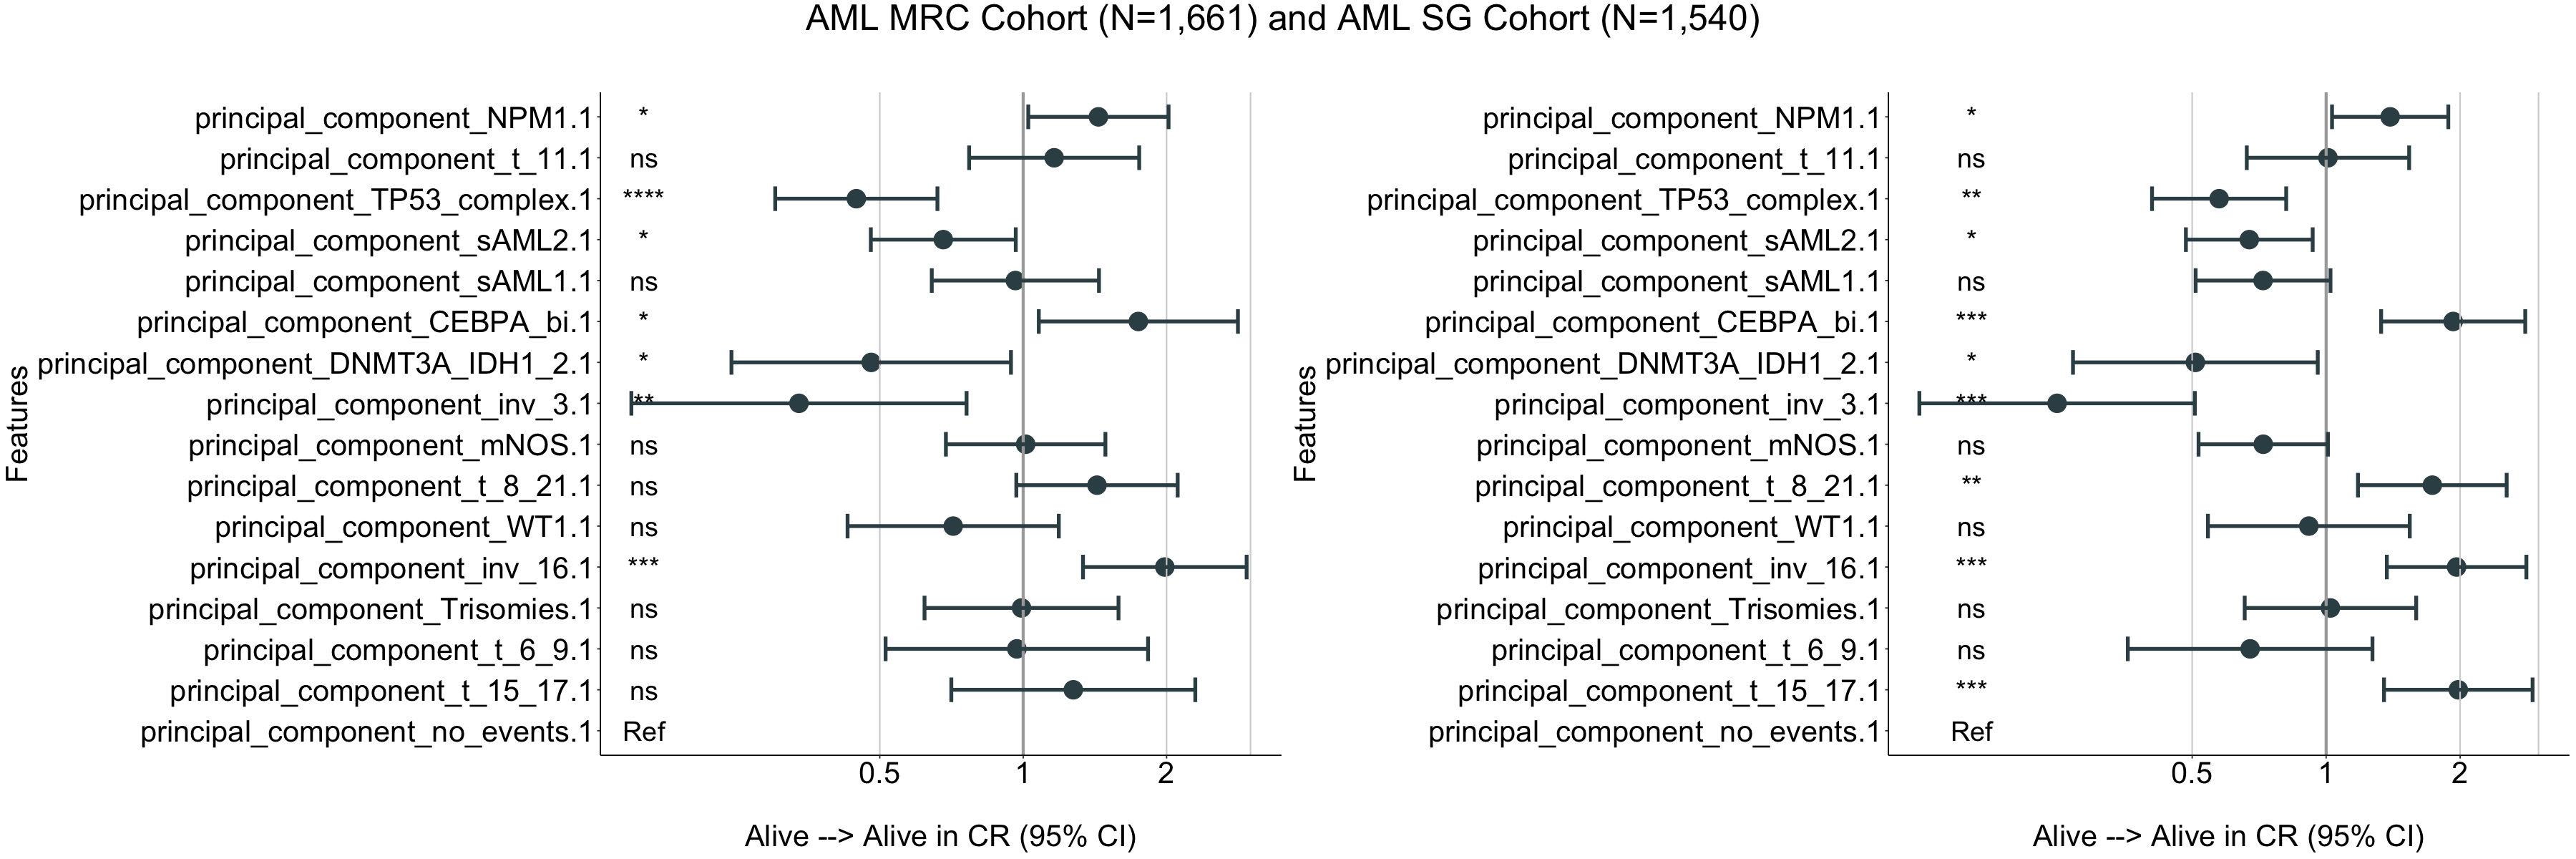

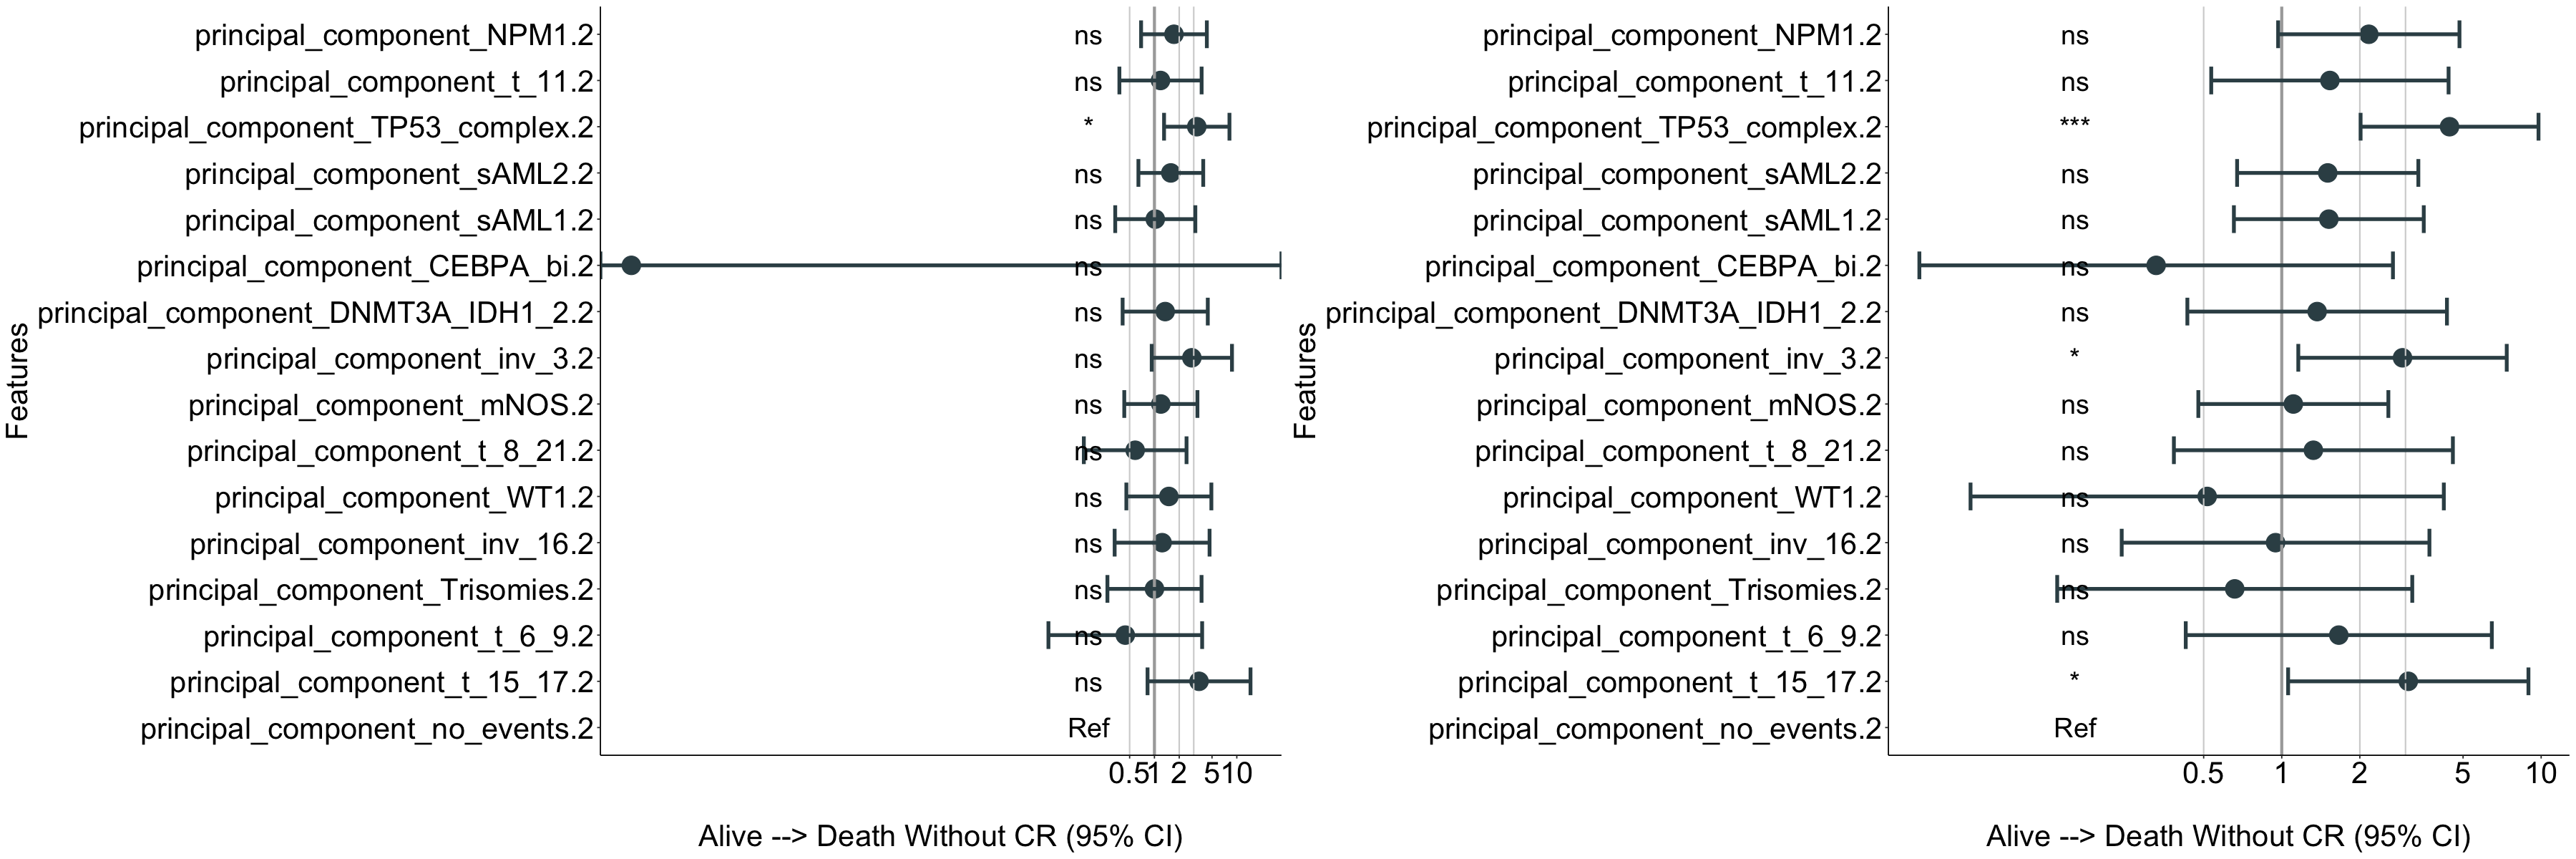

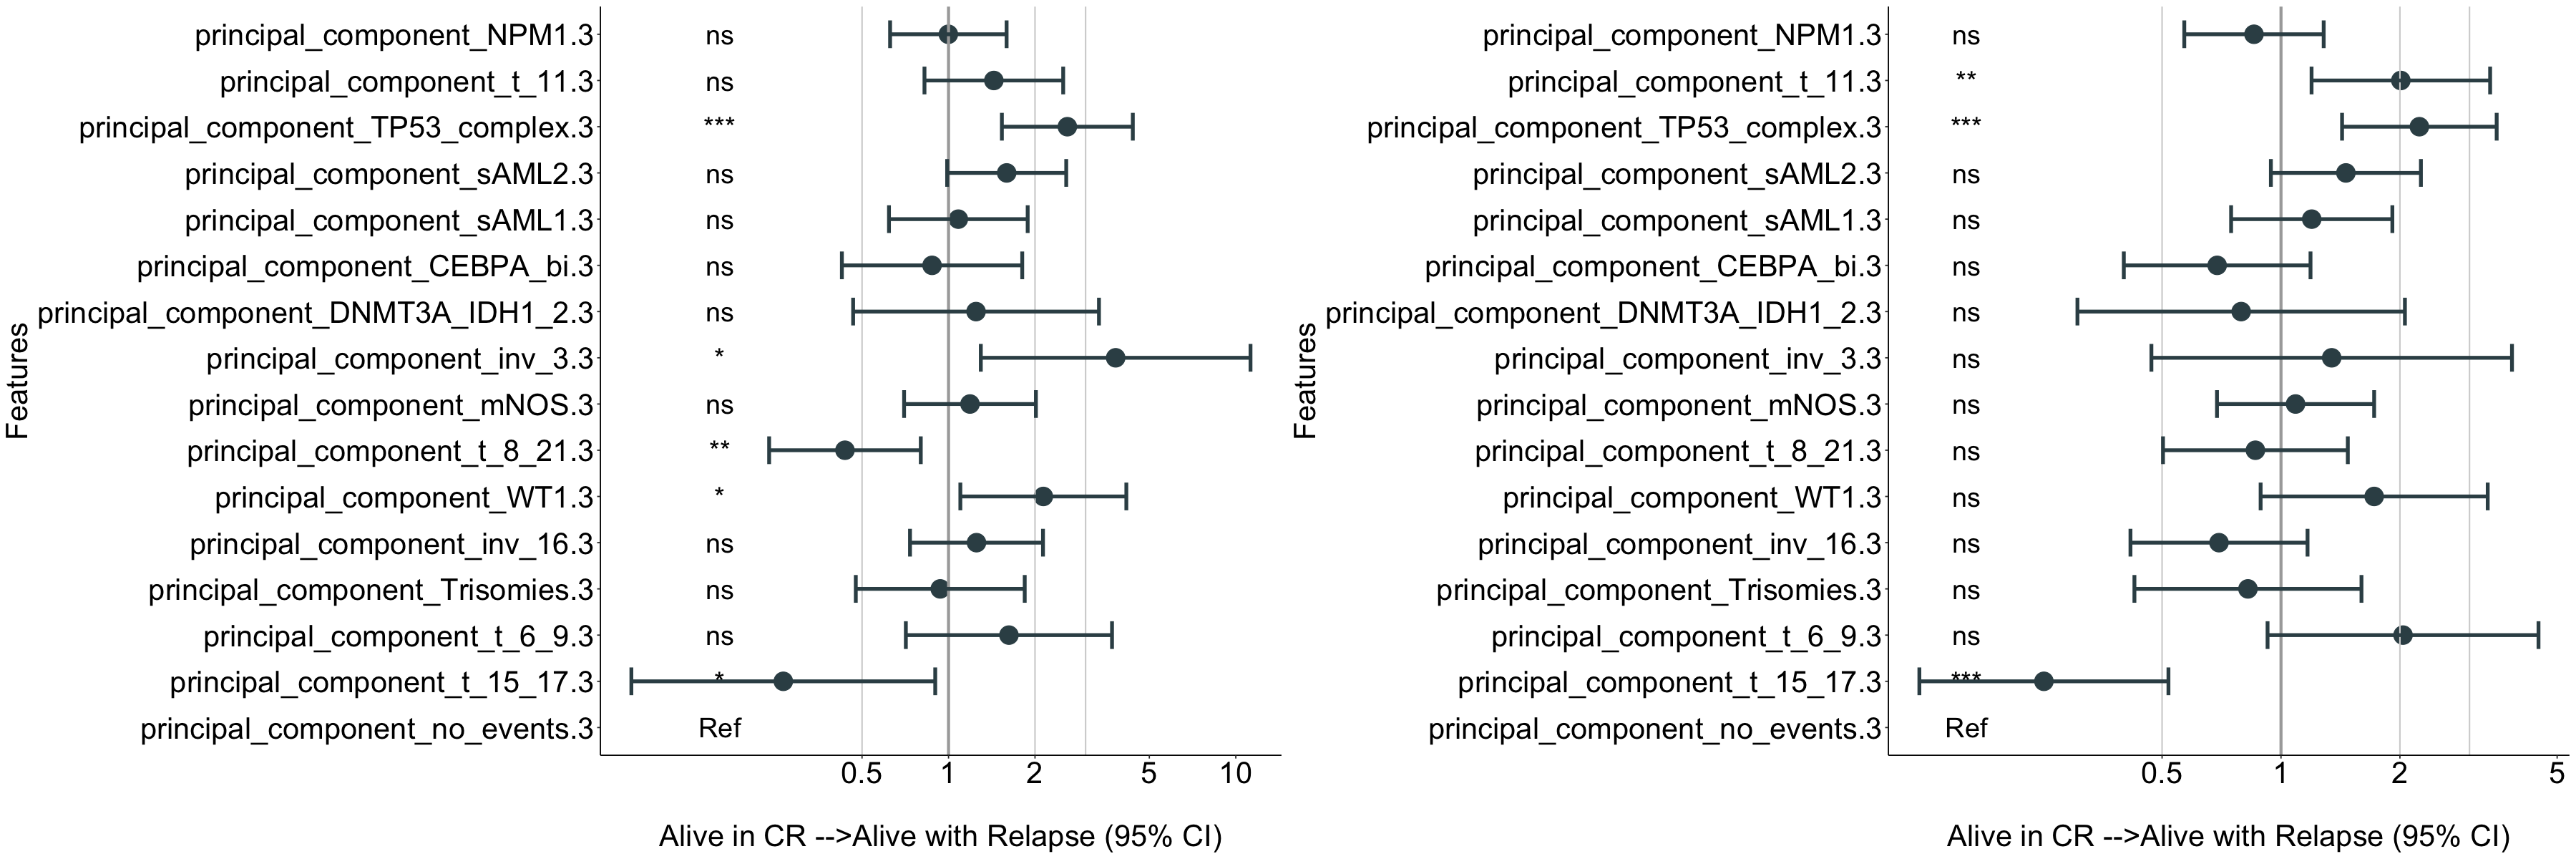

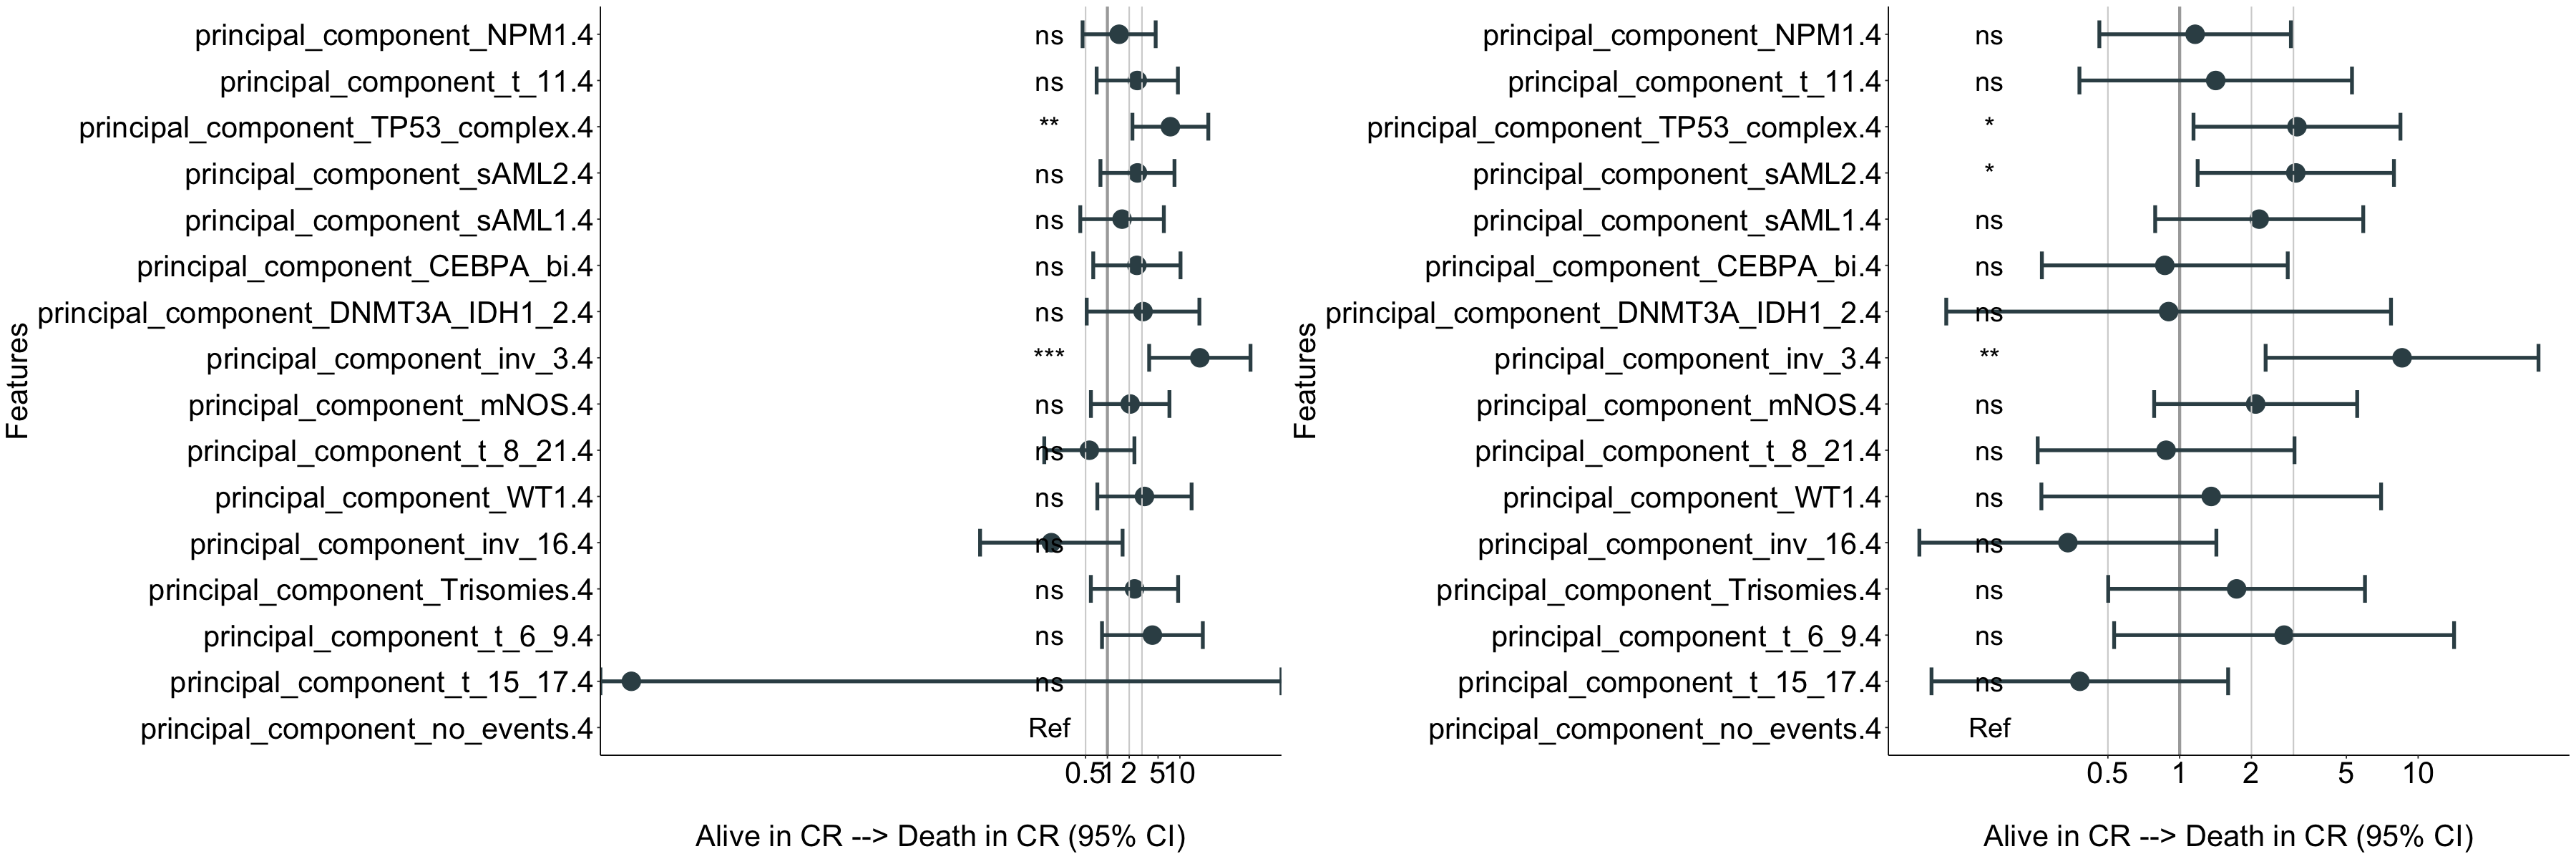

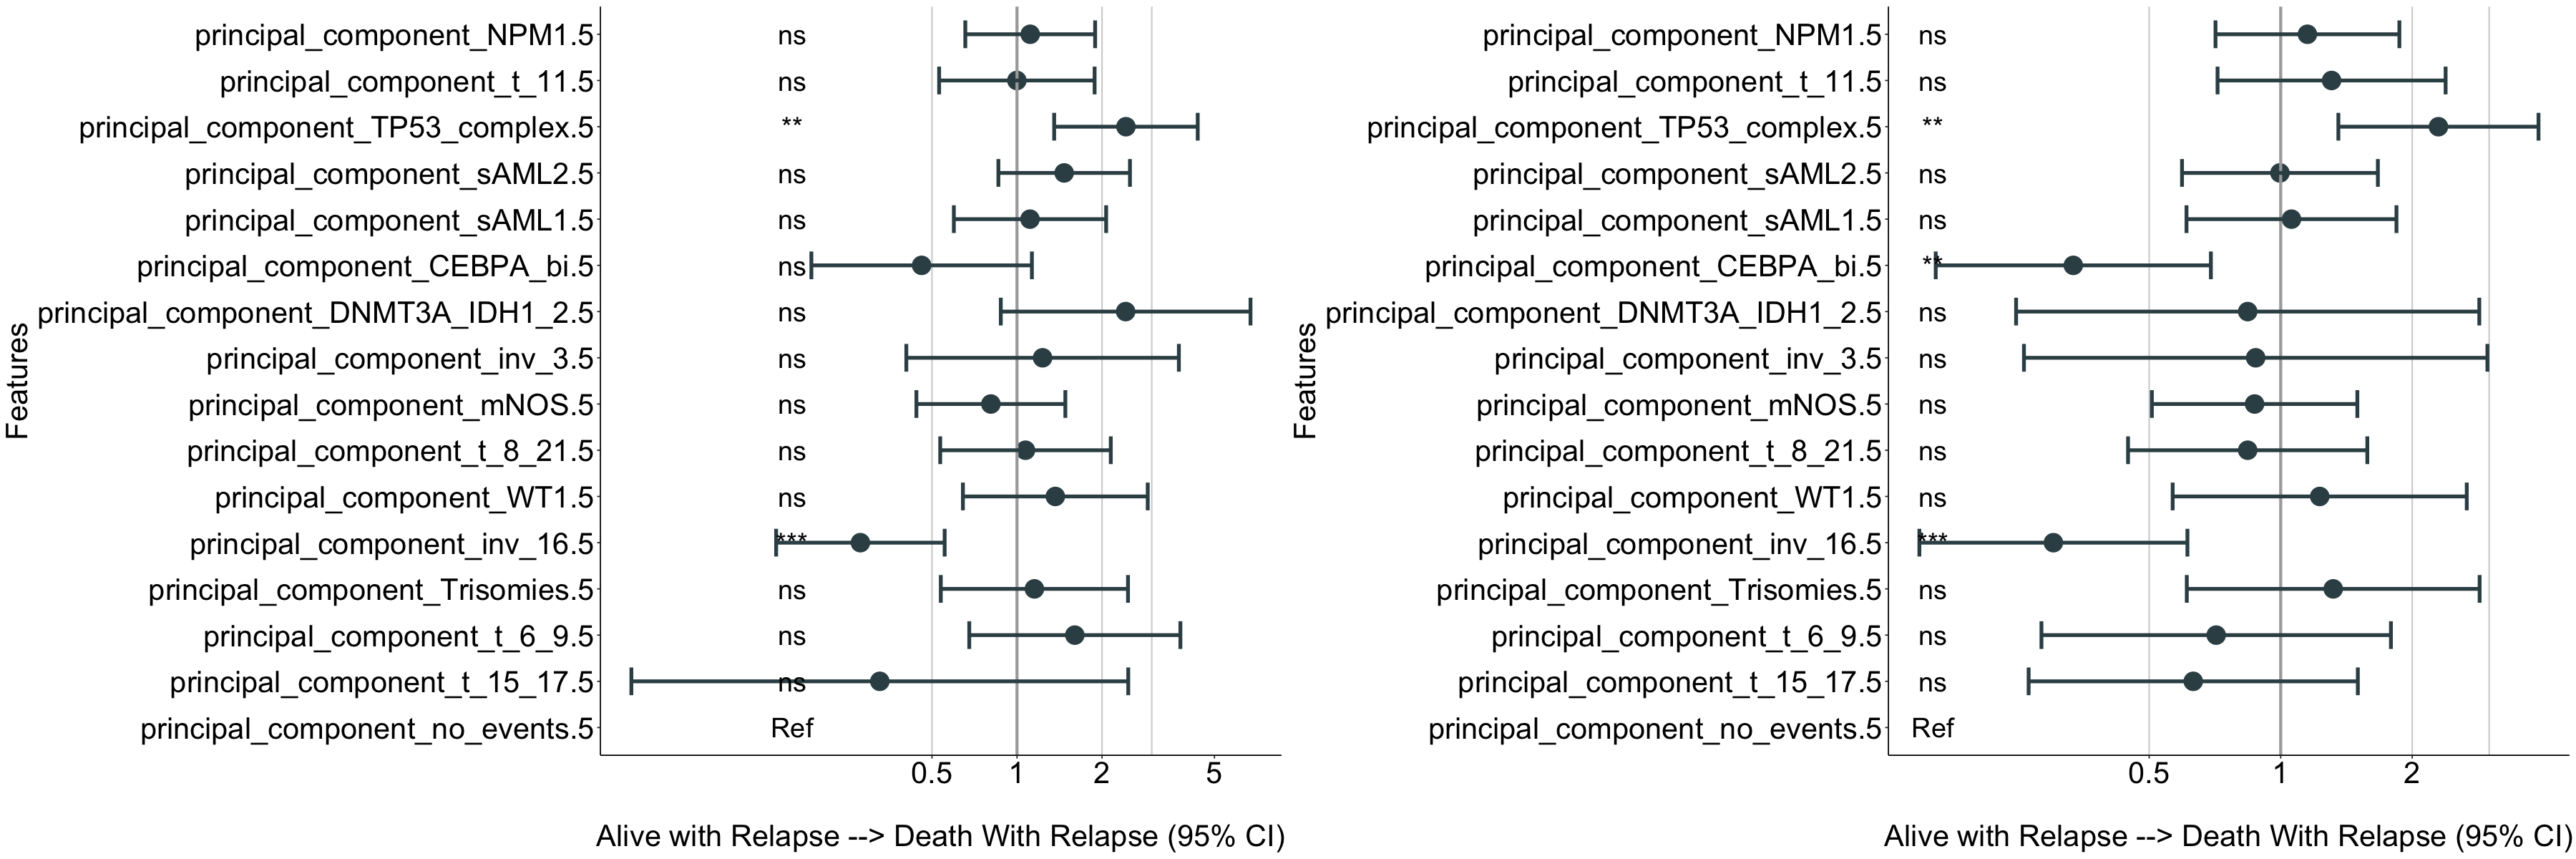

In [18]:
## Forest for each transitions comparing multivariate Cox coefficients for the classes in both datasets
set_notebook_plot_size(30,10)

for (i in 1:5){
  if(i==1){
    grid.arrange(p[[i]],p_val[[i]],nrow=1,top = textGrob("AML MRC Cohort (N=1,661) and AML SG Cohort (N=1,540) \n",gp=gpar(fontsize=30,font=1)))
  } else {
    grid.arrange(p[[i]],p_val[[i]],nrow=1)    
  }
}


# ****

# ****

# ****